# Preparing

## Import

In [6]:
import json
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import *
from matplotlib.dates import *

import datetime

In [ ]:
def get_df(file, header=None):                                                                 
    df = pd.read_csv(file, header=None)                                                        
    df.columns = pd.read_csv("{}.header".format(file.split('.csv')[0])).columns if header is None else header
    return df

DATA_DIR = '../../clusterdata/cluster-trace-gpu-v2020/data/'
dfs = get_df(DATA_DIR + 'pai_sensor_table.csv')
dfj = get_df(DATA_DIR + 'pai_job_table.csv')
dft = get_df(DATA_DIR + 'pai_task_table.csv')

# Select eligible jobs from the initial dataset

Eligible jobs are:
1. The job has sucessfully completed
2. The job is a *training* job (defined by "task_name" == "worker")
3. The job uses no GPU resources. *This can be changed when we update our power model to include GPUs*

In [15]:
# Criteria 2 and 3
selection = dfs[(dfs.gpu_wrk_util == 0) & \
                (dfs.task_name == "worker")]

# Criteria 1
selection = selection[selection.job_name.isin(dfj[dfj.status == "Terminated"].job_name)]

In [16]:
column_include = ["cpu_usage", "gpu_wrk_util", "read", "write"]

# Join with the tasks table to get the start and end time
df = dft[dft.task_name == "worker"][["job_name", "start_time", "end_time"]] \
                                           .join(other=selection.groupby("job_name")[column_include].sum(), on="job_name") \
                                           .dropna()

# Convert start and end times to datetime to make them easier to work with
df["start_time"] = pd.to_datetime(df.start_time, unit="s").dt.tz_localize("Asia/Shanghai")
df["end_time"] = pd.to_datetime(df.end_time, unit="s").dt.tz_localize("Asia/Shanghai")
df["runtime"] = df.end_time - df.start_time

## Generate trace

In [17]:
sample = df.sample(n=100, random_state=0)

In [26]:
def to_json(row: pd.Series) -> str:
    return json.dumps({"runtime_s": row.runtime.total_seconds(),
            "input_size_gb": row.read / 1e9, 
            "output_size_gb": row.write / 1e9,
            "core_count": row.cpu_usage / 100,
            "start_time": row.start_time.isoformat()})

sample.apply(to_json, axis=1).apply(print)

{"runtime_s": 141.0, "input_size_gb": 0.03356373688888889, "output_size_gb": 0.009619868777777778, "core_count": 1.52, "start_time": "1970-02-09T16:18:40+08:00"}
{"runtime_s": 294.0, "input_size_gb": 0.38629346157393485, "output_size_gb": 0.4247153953057644, "core_count": 2.8652941176470588, "start_time": "1970-02-09T07:13:54+08:00"}
{"runtime_s": 829.0, "input_size_gb": 0.017432657323529412, "output_size_gb": 0.008854835105882352, "core_count": 19.550359281437128, "start_time": "1970-01-31T00:40:05+08:00"}
{"runtime_s": 66.0, "input_size_gb": 0.028640983800000002, "output_size_gb": 0.0074330648, "core_count": 0.29714285714285715, "start_time": "1970-03-04T05:35:26+08:00"}
{"runtime_s": 1327.0, "input_size_gb": 0.0035751257472118963, "output_size_gb": 0.26032428135687735, "core_count": 0.20022641509433967, "start_time": "1970-02-27T15:31:33+08:00"}
{"runtime_s": 20724.0, "input_size_gb": 0.5942956345923244, "output_size_gb": 0.4912030020564809, "core_count": 3.6562768784730624, "start_

56870      None
371411     None
356630     None
1012492    None
1198865    None
           ... 
961510     None
147117     None
24284      None
798044     None
682711     None
Length: 100, dtype: object

In [24]:
df.runtime.describe()

count                        49774
mean     0 days 00:56:04.718708562
std      0 days 03:28:28.845548339
min                0 days 00:00:14
25%                0 days 00:01:03
50%                0 days 00:03:36
75%         0 days 00:21:58.750000
max                6 days 15:37:13
Name: runtime, dtype: object

## Eligible job characteristics

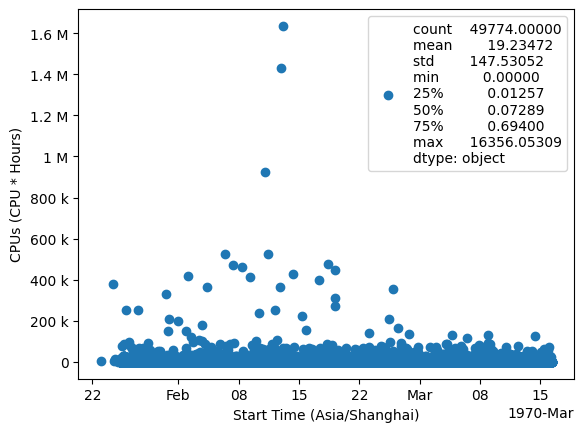

In [25]:
fig, ax = plt.subplots()
ax.scatter(df.start_time, df.cpu_usage * (df.runtime / pd.Timedelta(hours=1)), label=str((df.cpu_usage / 100 * (df.runtime / pd.Timedelta(hours=1))).describe().apply("{0:.5f}".format)))

locator = AutoDateLocator()
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(ConciseDateFormatter(locator))
ax.set_xlabel("Start Time (Asia/Shanghai)")

ax.yaxis.set_major_formatter(EngFormatter(unit=""))
ax.set_ylabel("CPUs (CPU * Hours)")

ax.legend()
plt.show()

In [32]:
min(df.start_time)

Timestamp('1970-01-23 07:26:14+0800', tz='Asia/Shanghai')

In [61]:
week = df[(df.start_time.dt.date >= datetime.date(year=1970, month=1, day=25)) &
          (df.start_time.dt.date <= (datetime.date(year=1970, month=1, day=25) + datetime.timedelta(days=1)))]

In [62]:
week.to_csv("day.csv")